# **Customer Attrition Prediction and Personalized Credit Card Recommendations for Banks**

Jeremy GARNEAU, Julien DEHUT, Tonghan WEN

# **Import packages and dataset**

In [ ]:
! kaggle datasets download thedevastator/predicting-credit-card-customer-attrition-with-m

Dataset URL: https://www.kaggle.com/datasets/thedevastator/predicting-credit-card-customer-attrition-with-m
License(s): CC0-1.0
  0% 0.00/379k [00:00<?, ?B/s]
100% 379k/379k [00:00<00:00, 74.5MB/s]


In [ ]:
!apt-get install unzip
!unzip predicting-credit-card-customer-attrition-with-m.zip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Archive:  predicting-credit-card-customer-attrition-with-m.zip
  inflating: BankChurners.csv        


In [ ]:
pip install xgboost

In [ ]:
pip install lightgbm

In [ ]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
import graphviz
import lightgbm as lgb
import time

from imblearn.over_sampling import RandomOverSampler

from collections import Counter

from numpy import mean

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, f1_score,precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV

from scipy.stats import randint

from IPython.display import Image, display

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **I) Function for convenience**

##**I.1 )Cross-validation score**

In [ ]:
def get_cross_val_score(fitted_model,num_cv=5):
  """
  Calculation of the cross-validation scores for a given machine learning model on different metrics:
    - F1-score
    - Precision
    - Recall
    - Accuracy

  fitted_model: the pre-trained model that will be evaluated (trained with x_ros and y_ros)
  num_cv: The number of cross-validation folds to use (default is 5)
  """

  #X_pca is the whole training set

  #F1-SCORE (harmonic mean of precision and recall, measuring the balance between correctly predicted positive observations and missed positive observations)
  f1_scorer=make_scorer(f1_score,average='weighted') #average='weighted' ensures that the F1-score is computed for each class separately and then weighted by the number of true instances for each class
  f1=cross_val_score(fitted_model, X_pca, y, cv=num_cv, scoring=f1_scorer)

  #PRECISION (proportion of correctly predicted positive observations out of all predicted positives)
  precision_scorer=make_scorer(precision_score,average='weighted')
  precision=cross_val_score(fitted_model,X_pca,y,cv=num_cv,scoring=precision_scorer)

  #RECALL (proportion of correctly predicted positive observations out of all actual positives)
  recall_scorer=make_scorer(recall_score,average='weighted')
  recall=cross_val_score(fitted_model,X_pca,y,cv=num_cv,scoring=recall_scorer)

  #ACCURACY (proportion of correctly classified observations out of the total number of observations)
  accuracy= cross_val_score(fitted_model, X_pca ,y,cv=num_cv, scoring='accuracy')

  #return the mean scores
  return mean(f1),mean(precision),mean(recall),mean(accuracy)

##**I.2) Test set score**

In [ ]:
def get_test_score(predictions):
  """
  Evaluates a machine learning model's performance on the test set.

  Parameters:
  predictions (array-like): Predicted labels for the test dataset.

  Returns:
  tuple: Accuracy, precision, recall, and F1-score for the given predictions.
  """

  # Calculate accuracy: the proportion of correct predictions out of all predictions
  accuracy = accuracy_score(y_test, predictions)

  # Calculate precision: the proportion of positive predictions that are correct
  precision = precision_score(y_test, predictions)

  # Calculate recall: the proportion of actual positives correctly identified
  recall = recall_score(y_test, predictions)

  # Calculate F1-score: the harmonic mean of precision and recall, useful for imbalanced datasets
  f1 = f1_score(y_test, predictions)

  # Return all four metrics as a tuple
  return accuracy, precision, recall, f1


#**II) Data Exploration and Pre processing**

##**II.1) Exploration**

In [ ]:
#read the data into a pandas dataframe
df=pd.read_csv('BankChurners.csv')

In [ ]:
#display the 5 first raws
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [ ]:
#shape of the dataframe
df.shape

(10127, 23)

In [ ]:
#columns
df.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

In [ ]:
# detecting missing values
df.isnull().sum()

,0
CLIENTNUM,0
Attrition_Flag,0
Customer_Age,0
Gender,0
Dependent_count,0
Education_Level,0
Marital_Status,0
Income_Category,0
Card_Category,0
Months_on_book,0


In [ ]:
#concise summary of the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

remove the doublons

In [ ]:
#look for doublons
df.duplicated().sum()
#so we could see there is no doublons in this dataset


0


handle the missing values

In [ ]:
#look for missing values
df.isnull().sum()
# so we dont need to handle the missing values for this dataset

,0
CLIENTNUM,0
Attrition_Flag,0
Customer_Age,0
Gender,0
Dependent_count,0
Education_Level,0
Marital_Status,0
Income_Category,0
Card_Category,0
Months_on_book,0


identify the imbalanced dataset

In [ ]:
#count the frequency of each unique value in the 'Attrition_Flag' column to assess class distribution
data_imbalanced=df['Attrition_Flag'].value_counts()

([<matplotlib.patches.Wedge at 0x7dedbd48d120>,
 [Text(-0.9628371444551311, 0.5319254019667504, ''),
  Text(0.9628371693563555, -0.5319253568930898, '')])

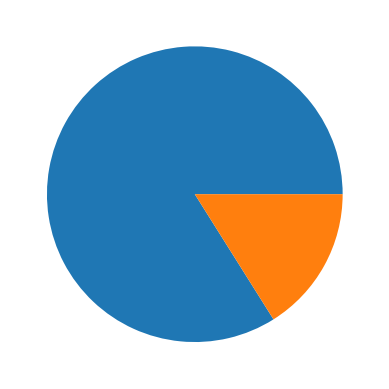

In [ ]:
#plot the result
plt.pie(data_imbalanced)

In [ ]:
#Create a new DataFrame containing only the 'Attrition_Flag' column
data_imbalanced2=df[['Attrition_Flag']]

<ipython-input-21-dc7420283678>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_imbalanced2,x='Attrition_Flag',palette='coolwarm')


<Axes: xlabel='Attrition_Flag', ylabel='count'>

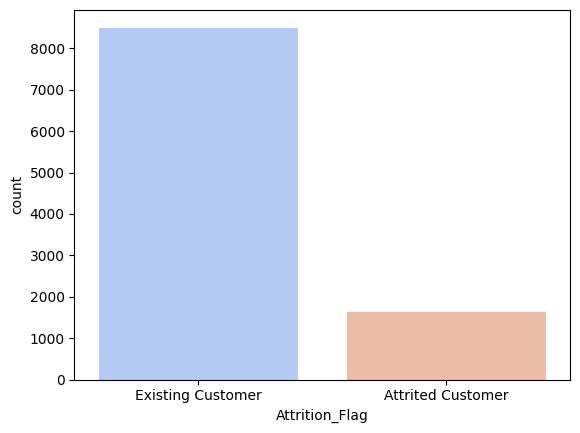

In [ ]:
#Visualization of the distribution of 'Attrition_Flag' values using a count plot to assess class imbalance in the dataset
sns.countplot(data=data_imbalanced2,x='Attrition_Flag',palette='coolwarm')

## **II. 2) Encoding the categorical data**
- Attrition flag --> label-encoding
- Gender --> label-encoding
- Education --> label encoding
- Marital status --> one-hot encoding (we don't want to attribute an order to marital status)
- Income category --> label encoding
- Card category --> label encoding

In [ ]:
df1 = df

#Initialization of the encoders
attrition_encoder = LabelEncoder()
gender_encoder = LabelEncoder()
marital_encoder = LabelEncoder()
oh_encoder = OneHotEncoder()

In [ ]:
# Attrition_Flag --> Label encoding
attrition_flag_encoder = LabelEncoder()
df1['Attrition_Flag'] = attrition_flag_encoder.fit_transform(df1['Attrition_Flag'])

# Gender --> Label encoding
gender_encoder = LabelEncoder()
df1['Gender'] = gender_encoder.fit_transform(df1['Gender'])

#Education --> label encoding
df1['Education_Level'].unique()
#we attribute the code
education_map = {
    'Uneducated': 0,
    'High School': 1,
    'College': 2,
    'Graduate': 3,
    'Post-Graduate': 4,
    'Doctorate': 5,
    'Unknown': 6
}
#and then, we replace the categorical data in the column by the numerical values attributed the line before
df1['Education_Level'] = df1['Education_Level'].replace(education_map)

# Marital_Status --> Label encoding
marital_status_encoder = LabelEncoder()
df1['Marital_Status'] = marital_status_encoder.fit_transform(df1['Marital_Status'])

#Income category --> label encoding
df1['Income_Category'].unique()
income_map = {
    'Less than $40K': 0,
    '$40K - $60K': 1,
    '$60K - $80K': 2,
    '$80K - $120K': 3,
    '$120K +': 4,
    'Unknown': 5
}
df1['Income_Category'] = df1['Income_Category'].replace(income_map)

#Card category --> label encoding
df1['Card_Category'].unique()
card_map = {
    'Blue': 0,
    'Silver': 1,
    'Gold': 2,
    'Platinum': 3
}
df1['Card_Category'] = df1['Card_Category'].replace(card_map)

#Print the first raws to see the transformations
df1.head()


<ipython-input-8-e63dbeed6e68>:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['Education_Level'] = df1['Education_Level'].replace(education_map)
<ipython-input-8-e63dbeed6e68>:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['Income_Category'] = df1['Income_Category'].replace(income_map)
<ipython-input-8-e63dbeed6e68>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,1,45,1,3,1,1,2,0,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,1,49,0,5,3,2,0,0,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,1,51,1,3,3,1,3,0,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,1,40,0,4,1,3,0,0,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,1,40,1,3,0,1,2,0,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [ ]:
#Table to summarize the transformations

#Attrition_Flag (label encoding)
attrition_flag_mapping = dict(zip(attrition_flag_encoder.classes_, attrition_flag_encoder.transform(attrition_flag_encoder.classes_)))
print("\nAttrition_Flag Encoding Mapping:")
print(attrition_flag_mapping)

#Gender (label encoding)
gender_mapping = dict(zip(gender_encoder.classes_, gender_encoder.transform(gender_encoder.classes_)))
print("\nGender Encoding Mapping:")
print(gender_mapping)

#Education_Level (personalized mapping)
print("\nEducation_Level Encoding Mapping:")
print(education_map)

#Marital_Status (label encoding)
marital_status_mapping = dict(zip(marital_status_encoder.classes_, marital_status_encoder.transform(marital_status_encoder.classes_)))
print("\nMarital_Status Encoding Mapping:")
print(marital_status_mapping)

#Income_Category (personalized mapping)
print("\nIncome_Category Encoding Mapping:")
print(income_map)

#Card_Category (personalized mapping)
print("\nCard_Category Encoding Mapping:")
print(card_map)



Attrition_Flag Encoding Mapping:
{'Attrited Customer': 0, 'Existing Customer': 1}

Gender Encoding Mapping:
{'F': 0, 'M': 1}

Education_Level Encoding Mapping:
{'Uneducated': 0, 'High School': 1, 'College': 2, 'Graduate': 3, 'Post-Graduate': 4, 'Doctorate': 5, 'Unknown': 6}

Marital_Status Encoding Mapping:
{'Divorced': 0, 'Married': 1, 'Single': 2, 'Unknown': 3}

Income_Category Encoding Mapping:
{'Less than $40K': 0, '$40K - $60K': 1, '$60K - $80K': 2, '$80K - $120K': 3, '$120K +': 4, 'Unknown': 5}

Card_Category Encoding Mapping:
{'Blue': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3}


## **II.3) Feature Selection and Dimension Reduction**

Correlation Analysis

In [ ]:
#removal of the columns Bayes”” columns which were the results of a classification algorithm added on the data as we will see a bit later (and really correlated)
df_remove=df1.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])

#correlations
df_corr=df_remove.corr()


In [ ]:
df_corr.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

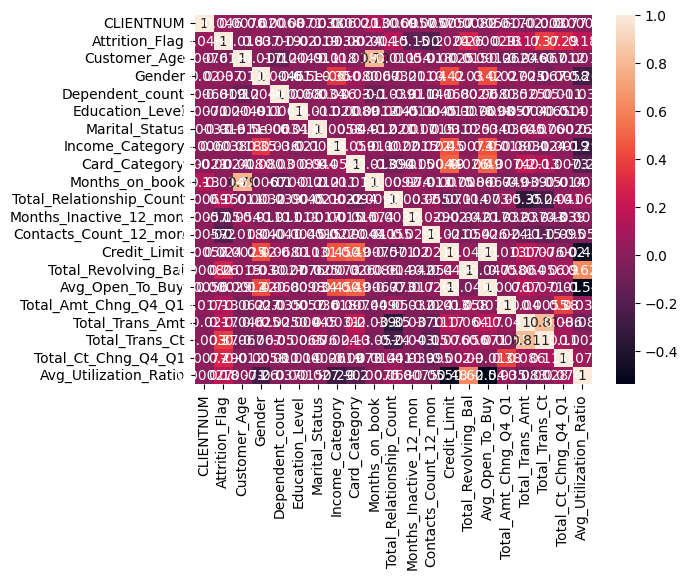

In [ ]:
#creation of a heatmap with columns to detect correlations
sns.heatmap(df_corr, annot=True)
plt.show()

In [ ]:
# drop the columns which don't belong to the original dataset
df1=df1.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])
# drop the columns which are highly correlated and we could clearly identyfy removing one wont have an impact on our result
df1=df1.drop(columns=['Avg_Open_To_Buy'])
# drop the column "CLIENTNUM" which serves as a unique identification but wont have a significant impact on target value
df1=df1.drop(columns=['CLIENTNUM'])

In [ ]:
df1.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
       'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

##**II.4) PCA Implementation**

In [ ]:
# Features: All columns except 'Attrition_Flag' used as input for PCA or modeling
X=df1.drop(columns=['Attrition_Flag'])

# Target: 'Attrition_Flag' column used as the target variable for classification tasks
y=df1['Attrition_Flag']

- Standardization (scale to 0-1)

In [ ]:
#To implement PCA, all input must be scaled to the range between 0 and 1

#Initialization of MinMaxScaler to scale features to a range between 0 and 1
scaler=MinMaxScaler()

#Fit the scaler to X and transform the data, scaling all features between 0 and 1
data_stand=scaler.fit_transform(X)

#Convert the scaled data back into a DataFrame for further use
X=pd.DataFrame(data_stand)

# Display X
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.404255,1.0,0.6,0.166667,0.333333,0.4,0.000000,0.604651,0.8,0.166667,0.500000,0.340190,0.308701,0.392994,0.035273,0.248062,0.437534,0.061061
1,0.489362,0.0,1.0,0.500000,0.666667,0.0,0.000000,0.720930,1.0,0.166667,0.333333,0.206112,0.343266,0.453636,0.043452,0.178295,1.000000,0.105105
2,0.531915,1.0,0.6,0.500000,0.333333,0.6,0.000000,0.534884,0.6,0.166667,0.000000,0.059850,0.000000,0.763615,0.076611,0.077519,0.628164,0.000000
3,0.297872,0.0,0.8,0.166667,1.000000,0.0,0.000000,0.488372,0.4,0.666667,0.166667,0.056676,1.000000,0.413600,0.036775,0.077519,0.628164,0.760761
4,0.297872,1.0,0.6,0.000000,0.333333,0.4,0.000000,0.186047,0.8,0.166667,0.000000,0.099091,0.000000,0.640271,0.017025,0.139535,0.673129,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0.510638,1.0,0.4,0.500000,0.666667,0.2,0.000000,0.627907,0.4,0.333333,0.500000,0.077536,0.735399,0.206947,0.832647,0.829457,0.230749,0.462462
10123,0.319149,1.0,0.4,1.000000,0.000000,0.2,0.000000,0.279070,0.6,0.333333,0.500000,0.085819,0.868494,0.236679,0.459219,0.457364,0.183899,0.511512
10124,0.382979,0.0,0.2,0.166667,0.333333,0.0,0.000000,0.534884,0.8,0.500000,0.666667,0.120042,0.000000,0.241095,0.544175,0.387597,0.220248,0.000000
10125,0.085106,1.0,0.4,0.500000,1.000000,0.2,0.000000,0.534884,0.6,0.500000,0.500000,0.116172,0.000000,0.157492,0.438689,0.403101,0.194400,0.000000


- plot the evolution of explained variance with the evolution of number of dimension to choose the most appropriate n_component

In [ ]:
#Define a list of integers from 1 to 12, representing the number of principal components to test
n_component=list(range(1,13))

#Initialization of an empty list to store the cumulative explained variance for each number of components
explained_variance=[]

#Calculation of explained variance for each component
for i in n_component:
  pca=PCA(n_components=i)
  X_pca=pca.fit(X)
  explained_variance.append(np.sum(pca.explained_variance_ratio_))

Text(0.5, 1.0, 'evolution of explained variance')

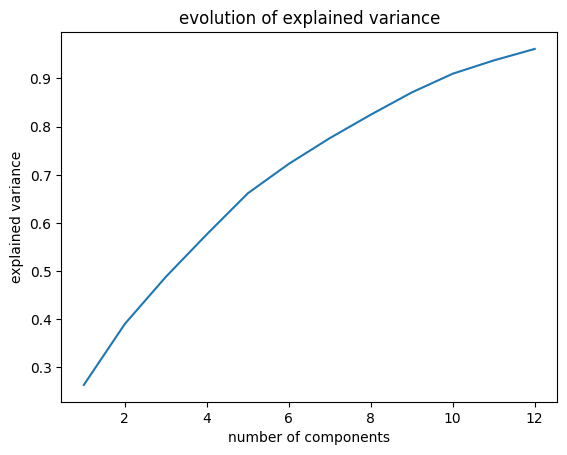

In [ ]:
#Plot the explained variance as a function of the number of components
plt.plot(n_component,explained_variance)
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.title('evolution of explained variance')

In [ ]:
#print an array of the results (results rounded 2 digits)
explained_variance_rounded = [round(val, 2) for val in explained_variance]

data_array = np.array([n_component, explained_variance_rounded]).T

print(data_array)

[[ 1.    0.26]
 [ 2.    0.39]
 [ 3.    0.49]
 [ 4.    0.58]
 [ 5.    0.66]
 [ 6.    0.72]
 [ 7.    0.78]
 [ 8.    0.82]
 [ 9.    0.87]
 [10.    0.91]
 [11.    0.94]
 [12.    0.96]]


In [ ]:
#based on the graph and the table above we choose to have 9 component which could reduce the dimensions and retain most infos

#Initialize PCA with 9 components to reduce the dimensionality of the dataset
pca=PCA(n_components=9)

#Fit the PCA model to the dataset 'X' to calculate principal components and explained variance
X_pca=pca.fit(X)

#Transform the original dataset 'X' into the new 9-dimensional space defined by the principal components
Result=pca.transform(X)

#Convert the transformed data into a DataFrame for further analysis or use
X_pca=pd.DataFrame(data=Result)

# Display X_pca
X_pca

,0,1,2,3,4,5,6,7,8
0,0.558288,-0.059989,-0.386153,0.215859,-0.175705,-0.133780,-0.142415,0.089845,-0.094396
1,-0.485266,-0.224896,-0.402078,0.009223,0.140963,-0.488709,0.162405,0.076483,-0.477219
2,0.563291,-0.325659,-0.341230,-0.097517,-0.065453,-0.032145,-0.359389,-0.195444,-0.051442
3,-0.699826,0.574621,0.170426,0.217002,-0.132028,-0.336990,0.236657,-0.432817,-0.265068
4,0.503442,-0.281202,-0.506160,0.302959,-0.379698,-0.307635,-0.231896,-0.087937,0.252044
...,...,...,...,...,...,...,...,...,...
10122,0.300214,0.440067,0.367957,-0.285749,-0.370409,0.069150,0.281002,0.031353,0.043644
10123,0.272629,0.619125,-0.028197,-0.628250,0.017834,-0.066951,-0.326920,0.295931,0.360076
10124,-0.468490,-0.557312,-0.258484,0.195933,-0.277965,0.143146,0.095870,0.335782,0.181558
10125,0.444447,-0.358304,-0.206799,-0.289653,-0.407342,-0.103137,0.429463,-0.305070,0.175264


In [ ]:
# Retrieve the variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the total explained variance across all selected components
sum_variance = np.sum(explained_variance_ratio)

sum_variance

0.871073116838869

In [ ]:
#this table tells us after pca, how components are linearly related with the different features(coefficient)
pd.DataFrame(pca.components_.T, index=X.columns)

#Each row corresponds to a principal component, and each column represents the contribution (loading) of a feature to that component

,0,1,2,3,4,5,6,7,8
0,-0.003838,0.004361,-0.011944,0.010914,0.025640,0.325936,-0.021905,0.045788,-0.544810
1,0.839288,0.273096,-0.174613,-0.209242,-0.357804,-0.012368,-0.044586,-0.079472,0.003272
2,0.016298,-0.034288,0.116029,0.007133,0.056880,-0.836751,-0.225947,-0.123608,-0.449452
3,-0.012288,-0.016826,-0.018361,-0.875814,0.480800,0.017550,-0.012658,0.007720,0.016693
4,0.004281,-0.035623,0.054831,-0.032124,-0.018738,-0.055800,0.797463,-0.572632,-0.142652
5,0.369757,-0.091495,0.179756,0.361742,0.659607,0.133819,-0.190663,-0.361044,0.150595
6,0.036735,-0.028358,0.080121,0.005708,0.025537,-0.028849,0.109672,0.169820,-0.033963
7,-0.001039,0.001457,-0.013301,0.010230,0.020154,0.347010,-0.022375,0.059398,-0.617437
8,-0.016004,0.117640,-0.763390,0.179136,0.304453,-0.187598,0.286825,0.272157,0.031702
9,-0.003435,-0.017249,-0.017369,0.006451,-0.007178,0.046879,-0.027252,-0.038731,-0.086622


## **II.5) Data Splitting and Oversampling**

Split the Data into Train and Test

In [ ]:
#stratify y because of classification task
X_train, X_test, y_train, y_test = train_test_split(X_pca,y,test_size=0.2, stratify=y, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8101, 9), (8101,), (2026, 9), (2026,))

OverSampling

In [ ]:
# Initialize a RandomOverSampler to balance the classes in the training set
ros = RandomOverSampler(random_state=42)

In [ ]:
# fit predictor and target variable
x_ros, y_ros = ros.fit_resample(X_train,y_train)

print('Original dataset shape', X_train.shape)
print('Resample dataset shape', x_ros.shape)

Original dataset shape (8101, 9)
Resample dataset shape (13598, 9)


In [ ]:
# Count the occurrences of each class label in the resampled target variable
df_imbalanced=y_ros.value_counts()

([<matplotlib.patches.Wedge at 0x7dedb760b460>,
 [Text(6.735557395310444e-17, 1.1, ''),
  Text(-2.0206672185931328e-16, -1.1, '')])

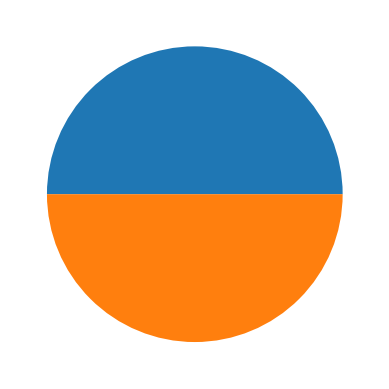

In [ ]:
#display a pie chart of the result
plt.pie(df_imbalanced)

In [ ]:
#display x_ros
x_ros

,0,1,2,3,4,5,6,7,8
0,-0.031461,-0.657011,-0.329606,0.498533,0.659195,0.066296,0.064691,-0.200981,-0.302830
1,0.542421,0.493863,0.238989,0.235880,-0.116961,0.513536,0.242512,-0.048485,0.027521
2,-0.518008,0.121496,0.282804,0.256761,-0.078928,-0.344165,0.058382,-0.152148,-0.084709
3,0.282751,0.465571,-0.384585,-0.442174,0.019730,-0.094693,-0.195398,0.004486,-0.146796
4,-0.149925,-0.396533,0.234741,0.233965,0.517450,0.244904,-0.285728,-0.189053,0.106465
...,...,...,...,...,...,...,...,...,...
13593,0.790980,-0.180750,0.168080,0.246687,-0.081789,-0.085711,-0.333063,0.018273,-0.447446
13594,0.650562,-0.374686,0.240373,0.278988,-0.392494,-0.235030,-0.397383,-0.153076,-0.350013
13595,0.792894,-0.185689,0.527444,-0.586284,0.130167,0.065151,-0.011022,0.412859,-0.024006
13596,-0.597624,0.348794,0.463303,-0.107818,-0.061082,-0.102847,-0.600344,0.182505,-0.311515


#**III) Models**

##**III.1) Churn prediction**

### **III.1) a) SVM**

#### **Training**

180 fits, 19 mins

In [ ]:
# Define the SVM classifier
svm = SVC(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 2],                # Smaller range for regularization
    'kernel': ['linear', 'rbf'],      # Focusing on simpler kernels
    'gamma': ['scale', 1],       # Reduced options for RBF kernel
    'class_weight': [None, 'balanced']
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1
)
grid_search.fit(x_ros, y_ros)

# Get the best parameters and best model
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.2f}")
best_model_svm = grid_search.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 2, 'class_weight': None, 'gamma': 1, 'kernel': 'rbf'}
Best Cross-Validation Score: 0.83


In [ ]:
best_model_svm = SVC(random_state=42, C=2, kernel='rbf', gamma=1, degree=2,class_weight = None)

####**Test**

In [ ]:
best_model_svm.fit(x_ros, y_ros)

SVC(C=2, degree=2, gamma=1, random_state=42)

####**Visualization Example**

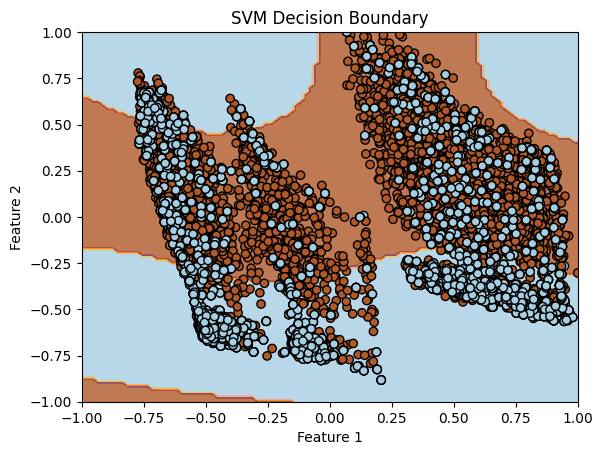

In [ ]:
# This visual shows an example for how we try to see the relationship between features and
# and how to separate them.

# Use only the first two features of x_ros for visualization
X_visual = x_ros.iloc[:, :2].values  # Assuming x_ros is a DataFrame
y_visual = y_ros.values  # Target labels

# Train a new SVM model on just the first two features
svm_visual = SVC(C=best_model_svm.C, kernel=best_model_svm.kernel, gamma=best_model_svm.gamma, degree=best_model_svm.degree, random_state=42)
svm_visual.fit(X_visual, y_visual)

# Create a mesh to plot decision boundaries
h = 0.02  # Step size in the mesh
x_min, x_max = X_visual[:, 0].min() - 1, X_visual[:, 0].max() + 1
y_min, y_max = X_visual[:, 1].min() - 1, X_visual[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict over the mesh grid
Z = svm_visual.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
plt.scatter(X_visual[:, 0], X_visual[:, 1], c=y_visual, cmap=plt.cm.Paired, edgecolors='k')
plt.title('SVM Decision Boundary')
plt.xlabel('Feature 1')  # Replace with actual feature names if available
plt.ylabel('Feature 2')  # Replace with actual feature names if available
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()


###**III.1) b) Random Forest**

#### **Training**

60 fits, 4 min

In [ ]:
# Initialize RF model
model = RandomForestClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [7,10,12],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',  # Metric to optimize
    cv=5,                # Number of folds
    verbose=1             #Verbosity of printing messages. Valid values of 0 (silent), 1 (warning), 2 (info), and 3 (debug)
)

# Perform grid search
grid_search.fit(x_ros, y_ros)

# Display the best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.2f}")
best_model_rf = grid_search.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'bootstrap': True, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Cross-Validation Score: 0.92


In [ ]:
best_model_rf = RandomForestClassifier(bootstrap = True, max_depth = 10, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 300)

####**Test**

In [ ]:
best_model_rf.fit(x_ros, y_ros)

RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=300)

####**Visualization Example**

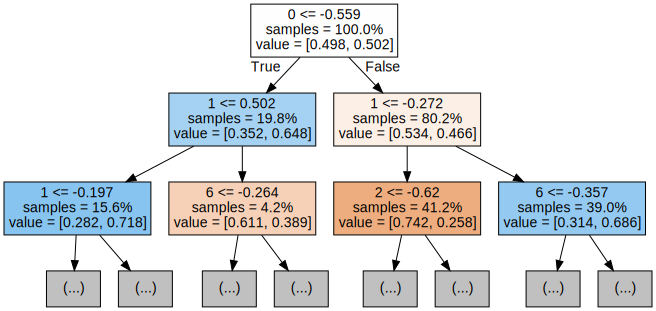

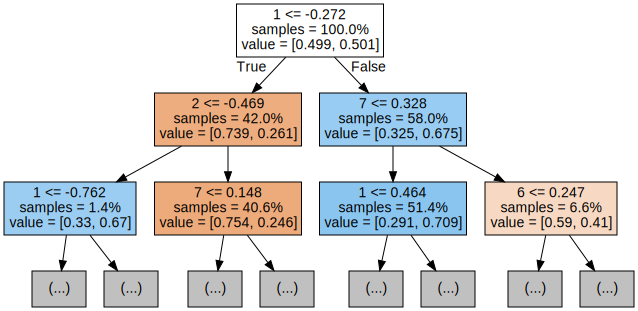

In [ ]:
# This code visualizes the first two decision trees from a trained RandomForestClassifier model.
# It uses the 'export_graphviz' function to generate Graphviz representations of each tree, limiting the depth of the tree to 2 levels.
# The visualization includes feature names, and the nodes are filled with colors based on class proportions, making the model easier to interpret.

for i in range(2):  # Replace 3 with the number of trees you want to visualize
    tree = best_model_rf.estimators_[i]  # Access individual trees
    dot_data = export_graphviz(
        tree,
        feature_names=[str(col) for col in X_train.columns],  # Convert feature names to strings
        filled=True,
        max_depth=2,
        impurity=False,
        proportion=True
    )
    graph = graphviz.Source(dot_data)
    display(graph)


### **III.1) c) C5 Tree**

####**Training**

C5.0 is a decision tree algorithm that is widely used in supervised learning. It is an updated version of the ID3 algorithm and is known for its high accuracy and performance.

C5.0 builds decision trees by selecting features that maximally differentiate between classes using information gain and gain ratio measures. It also incorporates pruning methods to prevent overfitting and improve generalization performance.

cross validation and model fine tuning-implement for whole dataset

In [ ]:
#dictionary of hyperparameters for tuning a Decision Tree model
tree_parameters={
    'max_depth':[3,5,7,9,13],            # Maximum depth of the tree, controlling how deep the tree can grow
    'min_samples_split':[5,7,9,11],   # Minimum number of samples required to split an internal node
    'min_samples_leaf':[1,3,7,13]           # Minimum number of samples required to be at a leaf node
}


#for trees, it's very likely to have overfitting
#so we focus on max_depth and min_sample_split, which could help us control the complexity of model


#max_depth: Affects how specific or general the model is. If it's too large, the tree might overfit by memorizing the training data. If it's too small, the model might underfit.
#min_samples_split and min_samples_leaf: Help control overfitting by ensuring that splits and leaves do not end up with very few samples, which might cause the tree to model noise in the data.

In [ ]:
#These hyperparameters can be used in GridSearchCV to search over different combinations of values, tuning the model for optimal performance
best_model_c5=GridSearchCV(DecisionTreeClassifier(),param_grid=tree_parameters,cv=5,n_jobs=-1,scoring='f1')

In [ ]:
best_model_c5=best_model_c5.best_estimator_

best_model_c5 #this is the model with the best parameters
#could directly use to calculate the result

DecisionTreeClassifier(max_depth=13, min_samples_split=5)

In [ ]:
best_model_c5=DecisionTreeClassifier(max_depth=13, min_samples_split=5)

####Test

In [ ]:
#Perform a search over hyperparameter values using cross-validation to find the best combination of hyperparameters for the model
best_model_c5.fit(x_ros,y_ros)

DecisionTreeClassifier(max_depth=13, min_samples_split=5)

###**III.1) d) XG-Boost**

####Train

In [ ]:
#this line had to be added to run correctly xgboost with gridsearch
!pip install scikit-learn==1.0.2

In [ ]:
# Initialize XGBoost model
model = XGBClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3],
    'n_estimators': [50, 100, 150]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',  # Metric to optimize
    cv=5,                # Number of folds
    verbose=1             #Verbosity of printing messages. Valid values of 0 (silent), 1 (warning), 2 (info), and 3 (debug)
)

# Perform grid search
grid_search.fit(x_ros, y_ros)

# Display the best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.2f}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150}
Best Cross-Validation Score: 0.83


In [ ]:
# Use the best model from GridSearchCV
best_model_xgb = grid_search.best_estimator_

NameError: name 'grid_search' is not defined

In [ ]:
best_model_xgb=XGBClassifier(learning_rate=0.2,max_depth=3,n_estimators=150)

####Test

In [ ]:
best_model_xgb.fit(x_ros, y_ros)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### **III.1) e) LightGBM**

#### **Training**

In [ ]:
lgbm = LGBMClassifier(random_state=42, verbose=-1)  # Suppress logs

param_grid = {
    'learning_rate': [0.2, 0.3, 0.4],
    'max_depth': [2,5],
    'n_estimators': [100,200],
    'min_child_weight': [2,5],
    'gamma': [1],
    'reg_lambda': [1],
    'reg_alpha': [1]
}

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1
)
grid_search.fit(x_ros, y_ros)

# Get the best parameters and best model
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.2f}")
best_model_lgbm = grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'gamma': 1, 'learning_rate': 0.4, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 1}
Best Cross-Validation Score: 0.95


In [ ]:
best_model_lgbm = LGBMClassifier(random_state=42, gamma = 1, learning_rate = 0.4, max_depth = 5, min_child_weight = 5, n_estimators = 300, reg_alpha= 1, reg_lambda= 1)

####**Test**

In [ ]:
best_model_lgbm.fit(x_ros, y_ros)

LGBMClassifier(gamma=1, learning_rate=0.4, max_depth=5, min_child_weight=5,
               n_estimators=300, random_state=42, reg_alpha=1, reg_lambda=1)

##III.2) Appropriate card

### **K-means clustering**

the idea of the recommendation is:
1. use K-means clustering to classify our customers and put them into different categorizations
2. for each categorization, find the card with highest customer retained ratio
3. for a new customer, provide them the card which could leads to potentially highest customer retained ratio

In [ ]:
#because recommendation based on the new customers, so we could only cluster the data based on the infos we could get from a new customer
#X is the data after transformation of numeric data but before pca
X.columns

Index(['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level',
       'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
       'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [ ]:
df1.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
       'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [ ]:
df_cluster=df1.drop(columns=['Attrition_Flag', 'Card_Category', 'Months_on_book','Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
       'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'])

In [ ]:
df_cluster

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category
0,45,1,3,1,1,2
1,49,0,5,3,2,0
2,51,1,3,3,1,3
3,40,0,4,1,3,0
4,40,1,3,0,1,2
...,...,...,...,...,...,...
10122,50,1,2,3,2,1
10123,41,1,2,6,0,1
10124,44,0,1,1,1,0
10125,30,1,2,3,3,1


In [ ]:
#identify the K
sse=[] # sum of squared error
for i in range(1,23):
  km=KMeans(n_clusters=i,random_state=33)
  km.fit(df_cluster)
  sse.append(km.inertia_)


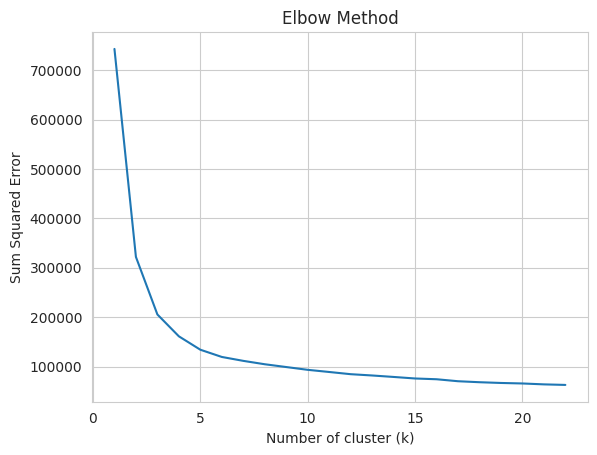

In [ ]:
sns.set_style("whitegrid")
g=sns.lineplot(x=range(1,23), y=sse)

g.set(xlabel ="Number of cluster (k)",
      ylabel = "Sum Squared Error",
      title ='Elbow Method')
plt.show()

so based on the elbow method, we decide the number of cluster to be 5

In [ ]:
km=KMeans(n_clusters=5,random_state=33)
km.fit(df_cluster)

KMeans(n_clusters=5, random_state=33)

In [ ]:
labels=km.predict(df_cluster)

In [ ]:
df_cluster['cluster']=labels

evaluate the clustering

In [ ]:
from sklearn.metrics import silhouette_score
data=df_cluster.drop(columns=['cluster'])
labels=df_cluster['cluster']
silhouette_avg = silhouette_score(data, labels)

In [ ]:
silhouette_avg

0.2892346735011551

Calculate the highest retention ratio for each cluster

In [ ]:
df=pd.read_csv('BankChurners.csv')
df_cluster['Card_Category']=df['Card_Category']
df_cluster['Attition_Flag']=df1['Attrition_Flag']
df_cluster

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,cluster,Card_Category,Attition_Flag
0,45,1,3,1,1,2,3,Blue,1
1,49,0,5,3,2,0,3,Blue,1
2,51,1,3,3,1,3,1,Blue,1
3,40,0,4,1,3,0,2,Blue,1
4,40,1,3,0,1,2,2,Blue,1
...,...,...,...,...,...,...,...,...,...
10122,50,1,2,3,2,1,1,Blue,1
10123,41,1,2,6,0,1,2,Blue,0
10124,44,0,1,1,1,0,3,Blue,0
10125,30,1,2,3,3,1,0,Blue,0


for each cluster, calculate the customer retain ratio based of each card
customer retain ratio=#retained customer/#total customer

In [ ]:
df_customer_retain=df_cluster.groupby(['cluster','Card_Category'])['Attition_Flag'].agg(['sum','count']).reset_index()
df_customer_retain

,cluster,Card_Category,sum,count
0,0,Blue,937,1074
1,0,Gold,8,11
2,0,Silver,49,55
3,1,Blue,1942,2317
4,1,Gold,21,23
5,1,Platinum,5,8
6,1,Silver,84,113
7,2,Blue,1953,2347
8,2,Gold,26,31
9,2,Platinum,4,5


In [ ]:
df_customer_retain['retain_ratio']=df_customer_retain['sum']/df_customer_retain['count']
#to exclude the extreme value and small sample, I add condition that the number of card user must >`10
df_customer_retain=df_customer_retain[df_customer_retain['count']>10].reset_index()
df_customer_retain

,index,cluster,Card_Category,sum,count,retain_ratio
0,0,0,Blue,937,1074,0.872439
1,1,0,Gold,8,11,0.727273
2,2,0,Silver,49,55,0.890909
3,3,1,Blue,1942,2317,0.838153
4,4,1,Gold,21,23,0.913043
5,6,1,Silver,84,113,0.743363
6,7,2,Blue,1953,2347,0.832126
7,8,2,Gold,26,31,0.838710
8,10,2,Silver,133,152,0.875000
9,11,3,Blue,2230,2683,0.831159


In [ ]:
df_customer_retain

,index,cluster,Card_Category,sum,count,retain_ratio
0,0,0,Blue,937,1074,0.872439
1,1,0,Gold,8,11,0.727273
2,2,0,Silver,49,55,0.890909
3,3,1,Blue,1942,2317,0.838153
4,4,1,Gold,21,23,0.913043
5,6,1,Silver,84,113,0.743363
6,7,2,Blue,1953,2347,0.832126
7,8,2,Gold,26,31,0.838710
8,10,2,Silver,133,152,0.875000
9,11,3,Blue,2230,2683,0.831159


In [ ]:
df_customer_retain.iloc[df_customer_retain.groupby('cluster')['retain_ratio'].idxmax()]

,index,cluster,Card_Category,sum,count,retain_ratio
2,2,0,Silver,49,55,0.890909
4,4,1,Gold,21,23,0.913043
8,10,2,Silver,133,152,0.875000
11,14,3,Silver,165,186,0.887097
13,17,4,Silver,42,49,0.857143


in this case, for a new customer, we could identify the cluster he/she belongs to and then recommend the most suitable card so that we could minimize the customer churn rate

# **IV) Comparing results**

In [ ]:
f1_svm,precision_svm,recall_svm,accuracy_svm = get_cross_val_score(best_model_svm)
predictions_svm_test=best_model_svm.predict(X_test)
accuracy_svm_test,precision_svm_test,recall_svm_test,f1_svm_test=get_test_score(predictions_svm_test)

In [ ]:
f1_rf,precision_rf,recall_rf,accuracy_rf = get_cross_val_score(best_model_rf)
predictions_rf_test=best_model_rf.predict(X_test)
accuracy_rf_test,precision_rf_test,recall_rf_test,f1_rf_test=get_test_score(predictions_rf_test)

In [ ]:
f1_c5,precision_c5,recall_c5,accuracy_c5=get_cross_val_score(best_model_c5)
predictions_c5=best_model_c5.predict(X_test)
accuracy_c5_test,precision_c5_test,recall_c5_test,f1_c5_test=get_test_score(predictions_c5)

In [ ]:
f1_xgb,precision_xgb,recall_xgb,accuracy_xgb = get_cross_val_score(best_model_xgb)
predictions_xgb = best_model_xgb.predict(X_test)
accuracy_xgb_test,precision_xgb_test,recall_xgb_test,f1_xgb_test=get_test_score(predictions_xgb)

In [ ]:
f1_lgbm,precision_lgbm,recall_lgbm,accuracy_lgbm=get_cross_val_score(best_model_lgbm)
predictions_lgbm_test=best_model_lgbm.predict(X_test)
accuracy_lgbm_test,precision_lgbm_test,recall_lgbm_test,f1_lgbm_test=get_test_score(predictions_lgbm_test)

[LightGBM] [Warning] Unknown parameter: gamma


(0.7769002961500494, 0.935191637630662, 0.7889476778365667, 0.8558673469387754)

In [ ]:
# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=[
    "Dataset", "Model", "Accuracy", "Precision", "Recall", "F1_Score"
])

# Function to add cross-validation and test results to the consolidated DataFrame
def add_to_results(model_name, cv_metrics, test_metrics):
    global results_df

    # Add Cross-Validation Metrics
    cv_row = pd.DataFrame({
        "Dataset": ["Cross-Validation"],
        "Model": [model_name],
        "Accuracy": [cv_metrics['Accuracy']],
        "Precision": [cv_metrics['Precision']],
        "Recall": [cv_metrics['Recall']],
        "F1_Score": [cv_metrics['F1-Score']]
    })
    results_df = pd.concat([results_df, cv_row], ignore_index=True)

    # Add Test Set Metrics
    test_row = pd.DataFrame({
        "Dataset": ["Test Set"],
        "Model": [model_name],
        "Accuracy": [test_metrics['Accuracy']],
        "Precision": [test_metrics['Precision']],
        "Recall": [test_metrics['Recall']],
        "F1_Score": [test_metrics['F1-Score']]
    })
    results_df = pd.concat([results_df, test_row], ignore_index=True)

# SVM
cv_metrics_svm = {
    'Accuracy': accuracy_svm,
    'Precision': precision_svm,
    'Recall': recall_svm,
    'F1-Score': f1_svm
}
test_metrics_svm = {
    'Accuracy': accuracy_svm_test,
    'Precision': precision_svm_test,
    'Recall': recall_svm_test,
    'F1-Score': f1_svm_test
}
add_to_results("SVM", cv_metrics_svm, test_metrics_svm)

# Repeat for other models (Random Forest, Decision Tree, etc.)
cv_metrics_rf = {
    'Accuracy': accuracy_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1-Score': f1_rf
}
test_metrics_rf = {
    'Accuracy': accuracy_rf_test,
    'Precision': precision_rf_test,
    'Recall': recall_rf_test,
    'F1-Score': f1_rf_test
}
add_to_results("Random Forest", cv_metrics_rf, test_metrics_rf)

cv_metrics_c5 = {
    'Accuracy': accuracy_c5,
    'Precision': precision_c5,
    'Recall': recall_c5,
    'F1-Score': f1_c5
}
test_metrics_c5 = {
    'Accuracy': accuracy_c5_test,
    'Precision': precision_c5_test,
    'Recall': recall_c5_test,
    'F1-Score': f1_c5_test
}
add_to_results("Decision Tree", cv_metrics_c5, test_metrics_c5)

cv_metrics_xgb = {
    'Accuracy': accuracy_xgb,
    'Precision': precision_xgb,
    'Recall': recall_xgb,
    'F1-Score': f1_xgb
}
test_metrics_xgb = {
    'Accuracy': accuracy_xgb_test,
    'Precision': precision_xgb_test,
    'Recall': recall_xgb_test,
    'F1-Score': f1_xgb_test
}
add_to_results("XGBoost", cv_metrics_xgb, test_metrics_xgb)

cv_metrics_lgbm = {
    'Accuracy': accuracy_lgbm,
    'Precision': precision_lgbm,
    'Recall': recall_lgbm,
    'F1-Score': f1_lgbm
}
test_metrics_lgbm = {
    'Accuracy': accuracy_lgbm_test,
    'Precision': precision_lgbm_test,
    'Recall': recall_lgbm_test,
    'F1-Score': f1_lgbm_test
}
add_to_results("LGBM", cv_metrics_lgbm, test_metrics_lgbm)

# Sort the consolidated results by Dataset (first), then by Model
results_df = results_df.sort_values(by=["Dataset"], ignore_index=True)

# Display the consolidated results
print(results_df)


            Dataset          Model  Accuracy  Precision    Recall  F1_Score
0  Cross-Validation            SVM  0.876271   0.864976  0.876271  0.856749
1  Cross-Validation  Random Forest  0.864518   0.846289  0.863926  0.839036
2  Cross-Validation  Decision Tree  0.793316   0.812003  0.794996  0.801502
3  Cross-Validation        XGBoost  0.863927   0.849354  0.863927  0.848666
4  Cross-Validation           LGBM  0.862742   0.846051  0.862742  0.847059
5          Test Set            SVM  0.827246   0.945875  0.842446  0.891169
6          Test Set  Random Forest  0.832182   0.918254  0.878307  0.897837
7          Test Set  Decision Tree  0.785785   0.908974  0.827748  0.866462
8          Test Set        XGBoost  0.807996   0.933289  0.830688  0.879005
9          Test Set           LGBM  0.776900   0.935192  0.788948  0.855867


<ipython-input-76-5fcb05c7e44e>:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, cv_row], ignore_index=True)


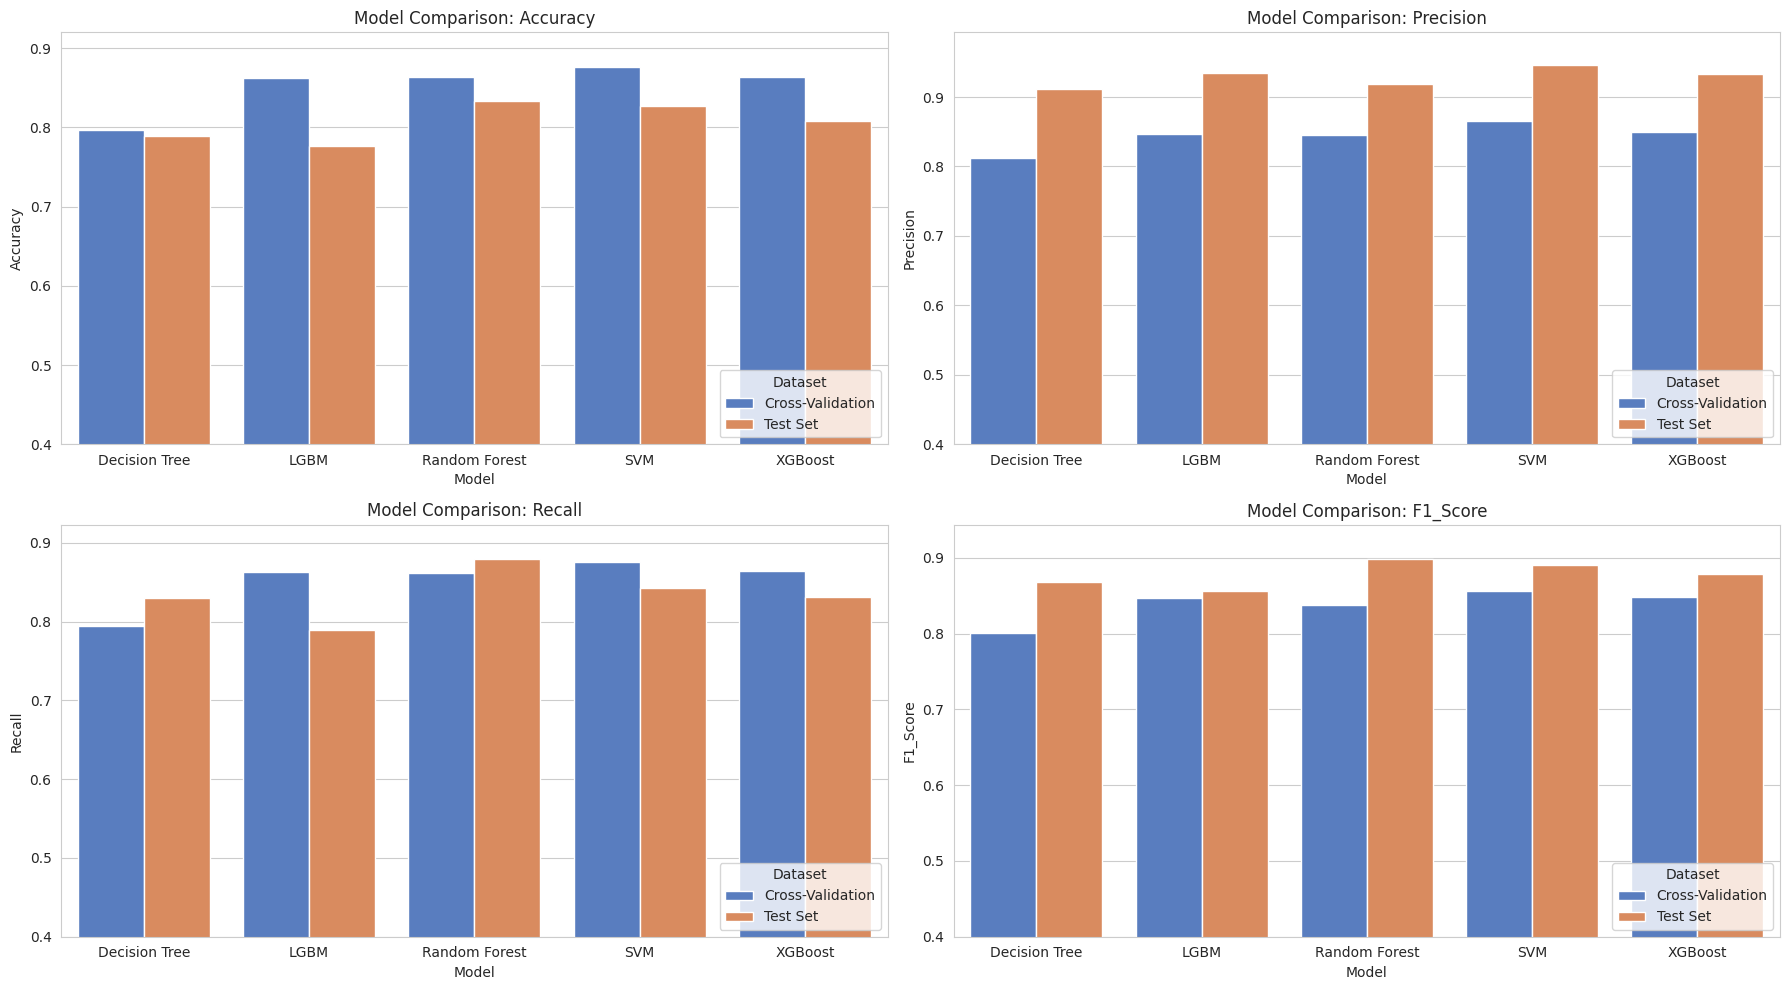

In [ ]:
# Set style for Seaborn plots
sns.set_style("whitegrid")

# Plot Accuracy, Precision, Recall, F1-Score, and FOR for each model
metrics = ["Accuracy", "Precision", "Recall", "F1_Score"]

# Set up the figure for subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.barplot(
        data=results_df,
        x="Model",
        y=metric,
        hue="Dataset",
        ax=axes[i],
        palette="muted"
    )
    axes[i].set_title(f"Model Comparison: {metric}")
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel("Model")
    axes[i].legend(title="Dataset", loc="lower right")

    axes[i].set_ylim(0.4, axes[i].get_ylim()[1]) #here to adjust vertical axis : 0; 0,4 or other value

# Adjust spacing between plots
plt.tight_layout()
plt.show()
